In [184]:
import cv2
from skimage.transform import resize
from os import listdir, walk
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

def gray_reshape(directory, new_size = (28,28), gray =True):
    """
    give the list of photos with the correct pixel size you want to 
    downsize. If you want Gray then write True.
    """
    items_resized  =[]
    pictures = []
    labels = []
    mapping = {'plants' : 0,'coins' : 1,'faces' : 2,'cups' : 3,'glasses' : 4,'pens' : 5,'gestures' : 6,'cutlery' : 7,'plates' : 8, 
                'nail_polishes' : 9  ,'shoes' : 10 
                }
    onlyfolders = [f for f in listdir(directory)]
    for idx, folder in enumerate(onlyfolders[1:]):
        pictures = [f for f in listdir(directory + folder) if isfile(join(directory + folder , f))]
        for idx, picture in enumerate(pictures):
            item = cv2.imread(directory + folder +'/'+ picture )
            labels.append(mapping[folder])
            
            if gray == True:
                item_gray = cv2.cvtColor(item, cv2.COLOR_BGR2GRAY)
                item_resized_gray = resize(item_gray, new_size)
                items_resized.append(item_resized_gray)
            else:
                item_resized_colored = resize(item, new_size)
                items_resized.append(item_resized_colored)
    return items_resized, labels

In [164]:
onlyfolders = [f for f in listdir('../output/')]
onlyfolders

['.DS_Store',
 'plants',
 'coins',
 'glasses',
 'pens',
 'gestures',
 'cutlery',
 'plates',
 'nail_polishes',
 'shoes',
 'cups',
 'faces']

In [165]:
X , y = gray_reshape('../output/', new_size = (160,160), gray =True);

#plt.imshow(X[8],cmap='Greys')
# Model / data parameters
num_classes = len(np.unique(y))
input_shape = (160, 160, 1)
# shuffle the data

shuffler = np.random.permutation(len(X))
X = np.array(X)
y = np.array(y)
X = X[shuffler]
y = y[shuffler]



In [170]:
# the data, split between train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# Scale images to the [0, 1] range
#### Normalise


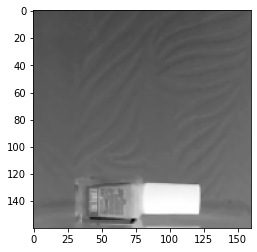

In [171]:
plt.imshow(X[8],cmap='Greys')

In [172]:
# Always always check shapes! 
X_train.shape, X_test.shape

((1042, 160, 160), (184, 160, 160))

In [175]:
x_train = X_train.astype("float32") / 255
x_test = X_test.astype("float32") / 255

# one hot encoder

y_train = keras.utils.to_categorical(y_train, num_classes)

y_test = keras.utils.to_categorical(y_test, num_classes)



In [179]:
# define the keras model.    the kernel size is the window that checks geometries: can be (3,3), (5,5), (7,7)
# Always clear the session!
K.clear_session()
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),   # number of neurons:  must be multiples of 2. good technique to start eith 8 and then we increase in the insede layers.
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
# model summary table
model.summary()

# define the batch size and number of epochs
batch_size = 5
epochs = 100




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 23104)             0         
                                                                 
 dropout (Dropout)           (None, 23104)             0

In [180]:
# complile and define eval metric
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])



In [181]:
# fit the model
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/100
188/188 [==============================] - 14s 72ms/step - loss: 2.3187 - accuracy: 0.1996 - val_loss: 2.2916 - val_accuracy: 0.1905
Epoch 2/100
188/188 [==============================] - 14s 73ms/step - loss: 2.2910 - accuracy: 0.2028 - val_loss: 2.2809 - val_accuracy: 0.1905
Epoch 3/100
188/188 [==============================] - 13s 68ms/step - loss: 2.2848 - accuracy: 0.2028 - val_loss: 2.2672 - val_accuracy: 0.1905
Epoch 4/100
188/188 [==============================] - 12s 64ms/step - loss: 2.2521 - accuracy: 0.2028 - val_loss: 2.2315 - val_accuracy: 0.1905
Epoch 5/100
188/188 [==============================] - 10s 51ms/step - loss: 2.1888 - accuracy: 0.2049 - val_loss: 2.1080 - val_accuracy: 0.1905
Epoch 6/100
188/188 [==============================] - 10s 52ms/step - loss: 1.9962 - accuracy: 0.2924 - val_loss: 1.8508 - val_accuracy: 0.3048
Epoch 7/100
188/188 [==============================] - 8s 45ms/step - loss: 1.6787 - accuracy: 0.4301 - val_loss: 1.7309 - val_acc

In [182]:
from tensorflow.keras.models import load_model

model.save("model_MNIST.h5")
# here you can stop your notebook
# moons_model = load_model("model_MNIST.h5")
# moons_model.summary()

In [189]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8351563811302185
Test accuracy: 0.782608687877655


In [264]:
mapping = {'plants' : 0,'coins' : 1,'faces' : 2,'cups' : 3,'glasses' : 4,'pens' : 5,'gestures' : 6,'cutlery' : 7,'plates' : 8, 
             'nail_polishes' : 9  ,'shoes' : 10 
             }
ynew = model.predict(x_test)
# show the inputs and predicted outputs
for idx, value in enumerate(ynew):
    print(f'With {np.max(value)} probability the model predicts that it is a {list(mapping)[np.where(value == np.max(value))[0][0]]}.')#
    print(f'The item is {list(mapping)[np.where(y_test[idx] == np.max(y_test[idx]))[0][0]]}.')
    


With 0.9991905093193054 probability the model predicts that it is a shoes.
The itme is shoes.
With 0.5590611696243286 probability the model predicts that it is a cups.
The itme is gestures.
With 0.9986056685447693 probability the model predicts that it is a shoes.
The itme is shoes.
With 0.9737407565116882 probability the model predicts that it is a plants.
The itme is plants.
With 0.5938536524772644 probability the model predicts that it is a faces.
The itme is plates.
With 0.9986889958381653 probability the model predicts that it is a coins.
The itme is cutlery.
With 0.93578040599823 probability the model predicts that it is a plates.
The itme is plates.
With 0.9990739822387695 probability the model predicts that it is a nail_polishes.
The itme is nail_polishes.
With 0.8932186961174011 probability the model predicts that it is a cutlery.
The itme is cutlery.
With 0.999488115310669 probability the model predicts that it is a coins.
The itme is coins.
With 0.9997609257698059 probabilit

In [261]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)